In [4]:
import re
import pandas as pd

def extract_experiments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    experiments = []
    current_experiment = {}
    accuracies = []
    epsilon_line = False
    if 'inf' in file_path or 'gap' in file_path:
        starts = "the value of hops"
    else:
        starts = "the value of epsilon"
    
    for line in lines:
        if epsilon_line:
            epsilon_line = False
            current_experiment['epsilon'] = float(line.strip())
        if line.startswith(starts):
            if current_experiment:  # Save the previous experiment if exists
                current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
                experiments.append(current_experiment)
                accuracies = []
            
            current_experiment = {}
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()
        
        if any(keyword in line for keyword in ["the value of beta", "the value of alpha_1", "the bound_lipschitz"]):
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()

        if 'gap' in file_path and any(keyword in line for keyword in ["epsilon:"]):
            params = line.strip().split(":")
            epsilon_line = True
        
        accuracy_match = re.search(r'test/acc\s+(\d+\.\d+)', line)
        if accuracy_match:
            accuracies.append(float(accuracy_match.group(1)))
    
    if current_experiment:  # Save the last experiment
        current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
        experiments.append(current_experiment)
    
    return experiments

# extract_experiments("gcn_chains2_inf.txt")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
def heatmap_caribou(group="epsilon", group2='bound_lipschitz', dataset='chains', exp_num=1, k='all', dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=0.8, label1='C_L', label2='epsilon'):
    experiments = []
    for i in range(7):
        if i == 6:
            file_path = f'output_heatmap/cl/caribou_{dataset}{exp_num}_inf.txt'
        else:
            file_path = f'output_heatmap/cl/caribou_{dataset}{exp_num}_e{2**i}.txt'
        experiments += extract_experiments(file_path)
    experiments_df = pd.DataFrame(experiments)
    experiments_df[group] = pd.to_numeric(experiments_df[group], errors='coerce')
    experiments_df[group2] = pd.to_numeric(experiments_df[group2], errors='coerce')
    experiments_df[group].fillna(-1, inplace=True)
    experiments_df[group2].fillna(-1, inplace=True)
    experiments_df['max_accuracy'] = pd.to_numeric(experiments_df['max_accuracy'], errors='coerce')
    experiments_df.sort_values(by=[group, group2], inplace=True)
    
    experiments_df = experiments_df[experiments_df['epsilon'] != -1]
    idx = experiments_df.groupby([group, group2])['max_accuracy'].idxmax()
    heatmap_data = experiments_df.loc[idx]
    # print(heatmap_data)
    heatmap_data.to_csv(f"heatmap_{dataset}_{group}_{group2}.csv")
    heatmap_data = heatmap_data.set_index([group, group2])['max_accuracy'].unstack()

    plt.rcParams['font.size'] = font_size
    plt.figure(dpi=dpi)
    plt.tight_layout()
    plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, square=square, cbar_kws={"shrink": cbar_shrink})
    cbar = plt.gcf().axes[-1]
    cbar.set_aspect('auto')
    # cbar.set_clim(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())
    # plt.title(f"Heatmap of Max Accuracy ({group} vs {group2})", pad=title_pad)
    if title is not None:
        plt.title(title, pad=title_pad)
    plt.xticks(ticks=np.arange(len(heatmap_data.columns))+0.5, labels=heatmap_data.columns.astype(int))
    plt.tick_params(axis='both', which='both', length=0)
    if label2 == 'epsilon':
        label2 = r'$\epsilon$'
    plt.xlabel(label2, fontsize=label_font_size)
    plt.ylabel(label1, fontsize=label_font_size)
    plt.xlabel(label2)
    plt.ylabel(label1)
    os.makedirs("../../AE_outputs/CRV/H", exist_ok=True)
    save_name = f"../../AE_outputs/CRV/H/heatmap_{dataset}{exp_num}_{group}_{group2}.png"
    # # plt.savefig(save_name, bbox_inches='tight')
    plt.savefig(save_name)
    plt.show()


/tmp/ipykernel_1088268/1989997541.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1088268/1989997541.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

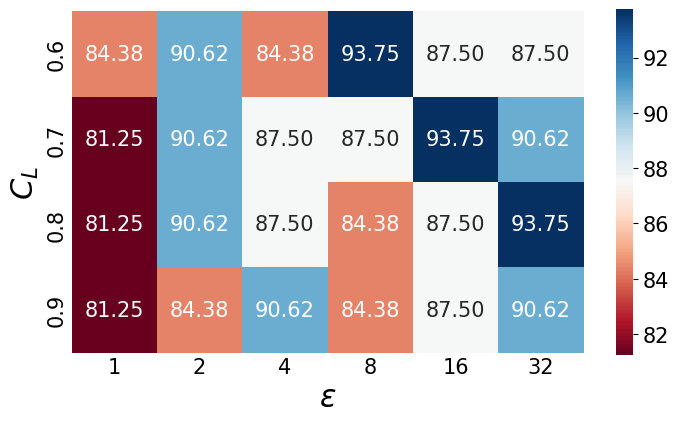

In [6]:
# chains 4
exp_num = ""
k = 'all'
heatmap_caribou('bound_lipschitz', 'epsilon', 'chains1', exp_num, k, dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=0.8, label1='$C_L$', label2='epsilon')

/tmp/ipykernel_1088268/1989997541.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1088268/1989997541.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

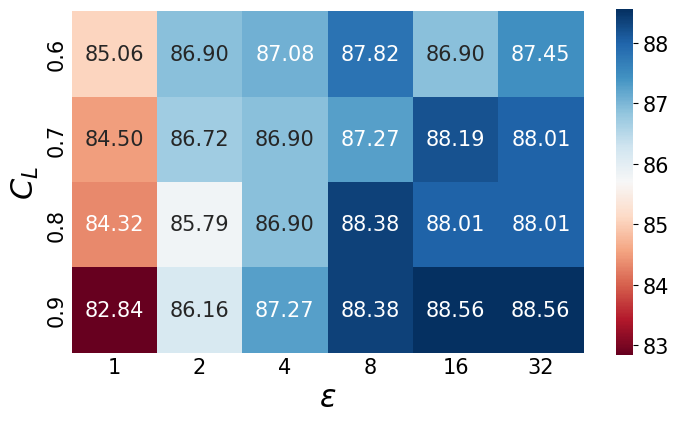

In [7]:
# cora
exp_num = ''
k = 'all'
heatmap_caribou('bound_lipschitz', 'epsilon', 'cora', exp_num, k, dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=0.8, label1='$C_L$', label2='epsilon')

In [8]:
import re
import pandas as pd

def extract_experiments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    experiments = []
    current_experiment = {}
    accuracies = []
    epsilon_line = False
    if 'inf' in file_path or 'gap' in file_path:
        starts = "the value of hops"
    else:
        starts = "the value of epsilon"
    
    for line in lines:
        if epsilon_line:
            epsilon_line = False
            current_experiment['epsilon'] = float(line.strip())
        if line.startswith(starts):
            if current_experiment:  # Save the previous experiment if exists
                current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
                experiments.append(current_experiment)
                accuracies = []
            
            current_experiment = {}
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()
        
        if any(keyword in line for keyword in ["the value of beta", "the value of alpha_1", "the bound_lipschitz"]):
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()

        if 'gap' in file_path and any(keyword in line for keyword in ["epsilon:"]):
            params = line.strip().split(":")
            epsilon_line = True
        
        accuracy_match = re.search(r'test/acc\s+(\d+\.\d+)', line)
        if accuracy_match:
            accuracies.append(float(accuracy_match.group(1)))
    
    if current_experiment:  # Save the last experiment
        current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
        experiments.append(current_experiment)
    
    return experiments

# extract_experiments("gcn_chains2_inf.txt")

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
def heatmap_caribou(group="epsilon", group2='bound_lipschitz', dataset='chains', exp_num=1, k='all', dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=0.8, label1='C_L', label2='epsilon'):
    experiments = []
    for i in range(6):
        if i == 6:
            file_path = f'output_heatmap/beta/caribou_{dataset}{exp_num}_inf.txt'
        else:
            file_path = f'output_heatmap/beta/caribou_{dataset}{exp_num}_e{2**i}.txt'
        experiments += extract_experiments(file_path)
    experiments_df = pd.DataFrame(experiments)
    experiments_df[group] = pd.to_numeric(experiments_df[group], errors='coerce')
    experiments_df[group2] = pd.to_numeric(experiments_df[group2], errors='coerce')
    experiments_df[group].fillna(-1, inplace=True)
    experiments_df[group2].fillna(-1, inplace=True)
    experiments_df['max_accuracy'] = pd.to_numeric(experiments_df['max_accuracy'], errors='coerce')
    experiments_df.sort_values(by=[group, group2], inplace=True)
    
    experiments_df = experiments_df[experiments_df['epsilon'] != -1]
    idx = experiments_df.groupby([group, group2])['max_accuracy'].idxmax()
    heatmap_data = experiments_df.loc[idx]
    # print(heatmap_data)
    heatmap_data.to_csv(f"heatmap_{dataset}_{group}_{group2}.csv")
    heatmap_data = heatmap_data.set_index([group, group2])['max_accuracy'].unstack()
    plt.rcParams['font.size'] = font_size
    plt.figure(dpi=dpi)
    plt.tight_layout()
    plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, square=square, cbar_kws={"shrink": cbar_shrink})
    cbar = plt.gcf().axes[-1]
    cbar.set_aspect('auto')
    # cbar.set_clim(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())
    # plt.title(f"Heatmap of Max Accuracy ({group} vs {group2})", pad=title_pad)
    if title is not None:
        plt.title(title, pad=title_pad)
    plt.xticks(ticks=np.arange(len(heatmap_data.columns))+0.5, labels=heatmap_data.columns.astype(int))
    plt.tick_params(axis='both', which='both', length=0)
    if label2 == 'epsilon':
        label2 = r'$\epsilon$'
    plt.xlabel(label2, fontsize=label_font_size)
    plt.ylabel(label1, fontsize=label_font_size)
    plt.xlabel(label2)
    plt.ylabel(label1)
    os.makedirs("../../AE_outputs/CRV/H", exist_ok=True)
    save_name = f"../../AE_outputs/CRV/H/heatmap_{dataset}{exp_num}_{group}_{group2}.png"
    # # plt.savefig(save_name, bbox_inches='tight')
    plt.savefig(save_name)
    plt.show()


/tmp/ipykernel_1088268/1766516997.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1088268/1766516997.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

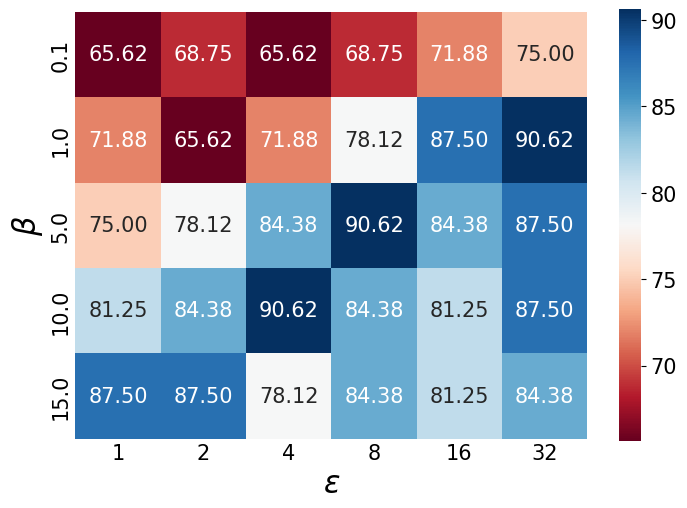

In [10]:
# chains 4
exp_num = 1
k = 'all'
heatmap_caribou('beta', 'epsilon', 'chains', exp_num, k, dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=1.0, label1='$\\beta$', label2='epsilon')

/tmp/ipykernel_1088268/1766516997.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1088268/1766516997.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

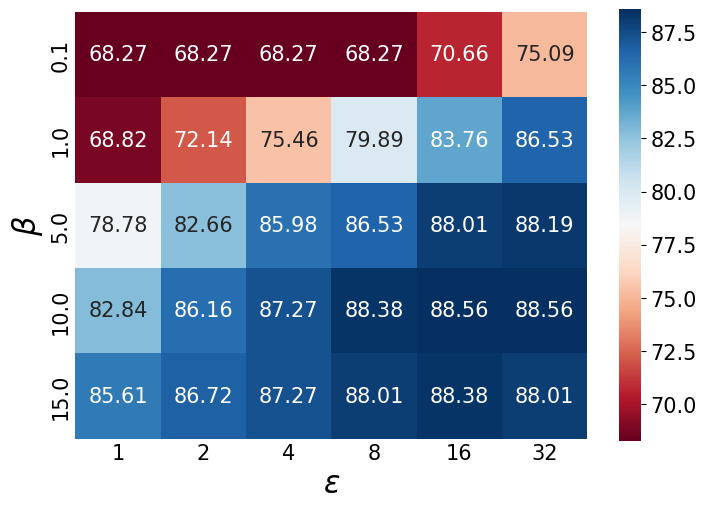

In [11]:
# cora
exp_num = ''
k = 'all'
heatmap_caribou('beta', 'epsilon', 'cora', exp_num, k, dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=1.0, label1='$\\beta$', label2='epsilon')

In [12]:
import re
import pandas as pd

def extract_experiments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    experiments = []
    current_experiment = {}
    accuracies = []
    epsilon_line = False
    if 'inf' in file_path or 'gap' in file_path:
        starts = "the value of hops"
    else:
        starts = "the value of epsilon"
    
    for line in lines:
        if epsilon_line:
            epsilon_line = False
            current_experiment['epsilon'] = float(line.strip())
        if line.startswith(starts):
            if current_experiment:  # Save the previous experiment if exists
                current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
                experiments.append(current_experiment)
                accuracies = []
            
            current_experiment = {}
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()
        
        if any(keyword in line for keyword in ["the value of beta", "the value of alpha_1", "the bound_lipschitz"]):
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()

        if 'gap' in file_path and any(keyword in line for keyword in ["epsilon:"]):
            params = line.strip().split(":")
            epsilon_line = True
        
        accuracy_match = re.search(r'test/acc\s+(\d+\.\d+)', line)
        if accuracy_match:
            accuracies.append(float(accuracy_match.group(1)))
    
    if current_experiment:  # Save the last experiment
        current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
        experiments.append(current_experiment)
    
    return experiments

# extract_experiments("gcn_chains2_inf.txt")

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
def heatmap_caribou(group="epsilon", group2='bound_lipschitz', dataset='chains', exp_num=1, k='all', dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=0.8, label1='C_L', label2='epsilon'):
    experiments = []
    for i in range(6):
        if i == 6:
            file_path = f'output_heatmap/alpha/caribou_{dataset}{exp_num}_inf.txt'
        else:
            file_path = f'output_heatmap/alpha/caribou_{dataset}{exp_num}_e{2**i}.txt'
        experiments += extract_experiments(file_path)
    experiments_df = pd.DataFrame(experiments)
    experiments_df[group] = pd.to_numeric(experiments_df[group], errors='coerce')
    experiments_df[group2] = pd.to_numeric(experiments_df[group2], errors='coerce')
    experiments_df[group].fillna(-1, inplace=True)
    experiments_df[group2].fillna(-1, inplace=True)
    experiments_df['max_accuracy'] = pd.to_numeric(experiments_df['max_accuracy'], errors='coerce')
    experiments_df.sort_values(by=[group, group2], inplace=True)
    
    experiments_df = experiments_df[experiments_df['epsilon'] != -1]
    idx = experiments_df.groupby([group, group2])['max_accuracy'].idxmax()
    heatmap_data = experiments_df.loc[idx]
    # print(heatmap_data)
    heatmap_data.to_csv(f"heatmap_{dataset}_{group}_{group2}.csv")
    heatmap_data = heatmap_data.set_index([group, group2])['max_accuracy'].unstack()
    plt.rcParams['font.size'] = font_size
    plt.figure(dpi=dpi)
    plt.tight_layout()
    plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, square=square, cbar_kws={"shrink": cbar_shrink})
    cbar = plt.gcf().axes[-1]
    cbar.set_aspect('auto')
    # cbar.set_clim(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())
    # plt.title(f"Heatmap of Max Accuracy ({group} vs {group2})", pad=title_pad)
    if title is not None:
        plt.title(title, pad=title_pad)
    plt.xticks(ticks=np.arange(len(heatmap_data.columns))+0.5, labels=heatmap_data.columns.astype(int))
    plt.tick_params(axis='both', which='both', length=0)
    if label2 == 'epsilon':
        label2 = r'$\epsilon$'
    plt.xlabel(label2, fontsize=label_font_size)
    plt.ylabel(label1, fontsize=label_font_size)
    plt.xlabel(label2)
    plt.ylabel(label1)
    os.makedirs("../../AE_outputs/CRV/H", exist_ok=True)
    save_name = f"../../AE_outputs/CRV/H/heatmap_{dataset}{exp_num}_{group}_{group2}.png"
    # plt.savefig(save_name, bbox_inches='tight')
    plt.savefig(save_name)
    plt.show()


/tmp/ipykernel_1088268/364341585.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1088268/364341585.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

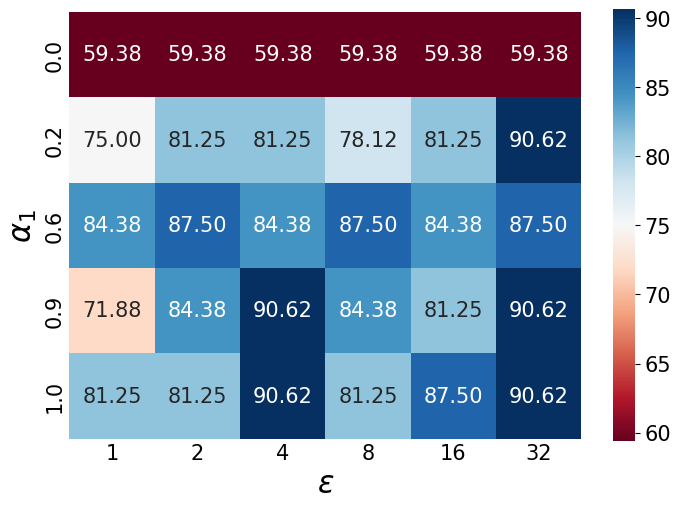

In [14]:
# chains 4
exp_num = 1
k = 'all'
heatmap_caribou('alpha_1', 'epsilon', 'chains', exp_num, k, dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=1, label1='$\\alpha_1$', label2='epsilon')

/tmp/ipykernel_1088268/364341585.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1088268/364341585.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

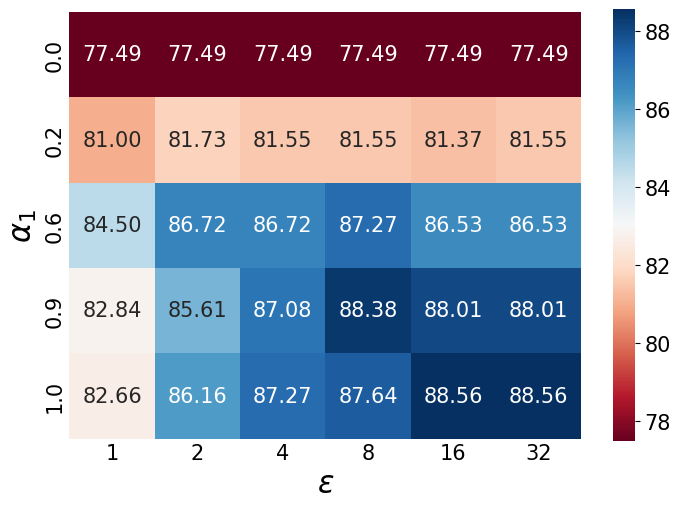

In [15]:
# cora
exp_num = ''
k = 'all'
heatmap_caribou('alpha_1', 'epsilon', 'cora', exp_num, k, dpi=100, font_size=15, label_font_size=22, square=True, cmap="RdBu", title=None, title_pad=20, cbar_shrink=1, label1='$\\alpha_1$', label2='epsilon')